<h1> <b>Sistem Rekomendasi Film<b> <h1> 

# Import Library

Mengimport library yang dibutuhkan


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# Data Loading

Mengunduh data dari sumber https://www.kaggle.com/datasets/bandikarthik/movie-recommendation-system kemudian diunggah melalui *google drive*. Mounted drive ke colab lalu unzip file dan terkahir memuat data ke dalam bentuk dataframe.

variabel yang ada pada dataset:

* links : merupakan daftar link film tersebut.
* movies : merupakan daftar film yang tersedia.
* ratings : merupakan daftar penilaian yang diberikan pengguna terhadap film.
* tags : merupakan daftar kata kunci dari film tersebut


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Dataset AI/Movie_Recommendation.zip"

Archive:  /content/drive/MyDrive/Dataset AI/Movie_Recommendation.zip
   creating: Movie_Recommendation/
  inflating: Movie_Recommendation/links.csv  
  inflating: Movie_Recommendation/movies.csv  
  inflating: Movie_Recommendation/ratings.csv  
  inflating: Movie_Recommendation/tags.csv  


In [ ]:
links = pd.read_csv('/content/Movie_Recommendation/links.csv')
movies = pd.read_csv('/content/Movie_Recommendation/movies.csv')
ratings = pd.read_csv('/content/Movie_Recommendation/ratings.csv')
tags = pd.read_csv('/content/Movie_Recommendation/tags.csv')

# EDA - Analisis Univariate 
Analisis univariate merupakan proses untuk mengeksplorasi dan menjelaskan setiap variabel dalam kumpulan data secara terpisah. 

## Variabel links

In [ ]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34208 entries, 0 to 34207
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  34208 non-null  int64  
 1   imdbId   34208 non-null  int64  
 2   tmdbId   33912 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 801.9 KB


Dapat dilihat bahwa :

*   Terdapat 34208 data dalam links
*   Terdapat 2 buah kolom bertipe int64 yaitu movieId dan imdbId 
*   Terdapat 1 buah kolom bertipe float64 yaitu tmdbId 



In [ ]:
print('Jumlah data link film : ', len(links.movieId.unique()))

Jumlah data link film :  34208


Dapat dilihat bahwa jumlah data link film berdasarkan movieId sebanyak 34208

## Variabel movies

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34208 entries, 0 to 34207
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  34208 non-null  int64 
 1   title    34208 non-null  object
 2   genres   34208 non-null  object
dtypes: int64(1), object(2)
memory usage: 801.9+ KB


Dapat dilihat bahwa :

*   Terdapat 34208 data dalam links
*   Terdapat 1 buah kolom bertipe int64 yaitu movieId
*   Terdapat 2 buah kolom bertipe object yaitu title dan genres 



In [ ]:
print('Jumlah data movie : ', len(movies.movieId.unique()))
print('Banyak judul film: ', len(movies.title.unique()))
print('Banyak Genre: ', len(movies.genres.unique()))

Jumlah data movie :  34208
Banyak judul film:  34185
Banyak Genre:  1446


## Variabel ratings

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22884377 entries, 0 to 22884376
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 698.4 MB


Dapat dilihat bahwa :

*   Terdapat 22884377 data dalam links
*   Terdapat 3 buah kolom bertipe int64 yaitu userId, movieId dan timestamp
*   Terdapat 1 buah kolom bertipe float64 yaitu rating

Karena data terlalu banyak, maka data yang akan digunakan hanya 30000 data saja

In [ ]:
# mengambil data sebanyak 30000
ratings = ratings.iloc[:30000,:]

In [ ]:
# cek bentuk data 
ratings.shape

(30000, 4)

In [ ]:
print('Jumlah data ratings dari user : ', len(ratings.userId.unique()))
print('Jumlah data ratings dari movie : ', len(ratings.movieId.unique()))

Jumlah data ratings dari user :  351
Jumlah data ratings dari movie :  5380


In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,30000.000000,30000.000000,30000.000000,3.000000e+04
mean,163.875767,11711.897767,3.487700,1.132281e+09
std,100.419974,24747.244802,1.141019,1.794357e+08
min,1.000000,1.000000,0.500000,8.270984e+08
25%,74.000000,919.000000,3.000000,9.742371e+08
50%,166.000000,2289.000000,4.000000,1.124478e+09
75%,247.000000,5060.000000,4.000000,1.287274e+09
max,351.000000,148667.000000,5.000000,1.453995e+09


Dapat kita lihat dari nilai max dan min bahwa nilai rating terbesar yaitu 5 dan nilai rating terkecil yaitu 0.5

## Variabel tags

In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586994 entries, 0 to 586993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     586994 non-null  int64 
 1   movieId    586994 non-null  int64 
 2   tag        586978 non-null  object
 3   timestamp  586994 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 17.9+ MB


Dapat dilihat bahwa :

*   Terdapat 586994 data dalam links
*   Terdapat 3 buah kolom bertipe int64 yaitu userId, movieId dan timestamp
*   Terdapat 1 buah kolom bertipe object yaitu tag

Karena data terlalu banyak, maka data yang akan digunakan hanya 30000 data saja

In [ ]:
tags = tags.iloc[:30000,:]

In [ ]:
tags.shape

(30000, 4)

In [ ]:
print('Banyak tag: ', len(tags.tag.unique()))

Banyak tag:  6509


# Content Based Filtering

## Data Preprocessing



### Menggabungkan Movie

In [ ]:
import numpy as np
 
# Menggabungkan seluruh movieId pada kategori movie
movie_all = np.concatenate((
    links.movieId.unique(),
    movies.movieId.unique(),
    ratings.movieId.unique(),
    tags.movieId.unique(),
))
 
# Mengurutkan data dan menghapus data yang sama
movie_all = np.sort(np.unique(movie_all))
 
print('Jumlah seluruh data movie berdasarkan movieID: ', len(movie_all))

Jumlah seluruh data movie berdasarkan movieID:  34208


### Menggabungkan User

In [ ]:
# Menggabungkan seluruh userId
user_all = np.concatenate((
    ratings.userId.unique(),
    tags.userId.unique(),
   
))
 
# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all)) 
 
print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  1095


### Menggabungkan seluruh data dengan fitur nama film

In [ ]:
# Definisikan dataframe rating ke dalam variabel all_movie_rate
all_movie_rate = ratings
all_movie_rate

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496
...,...,...,...,...
29995,351,1222,5.0,1331586142
29996,351,1225,5.0,1331586080
29997,351,1240,5.0,1331585767
29998,351,1258,5.0,1331586159


In [ ]:
all_movie_name = pd.merge(all_movie_rate, movies[['movieId','title','genres']], on='movieId', how='left')
all_movie_name

,userId,movieId,rating,timestamp,title,genres
0,1,169,2.5,1204927694,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama
1,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy
2,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller
3,2,2571,3.5,1436165433,"Matrix, The (1999)",Action|Sci-Fi|Thriller
4,2,109487,4.0,1436165496,Interstellar (2014),Sci-Fi|IMAX
...,...,...,...,...,...,...
29995,351,1222,5.0,1331586142,Full Metal Jacket (1987),Drama|War
29996,351,1225,5.0,1331586080,Amadeus (1984),Drama
29997,351,1240,5.0,1331585767,"Terminator, The (1984)",Action|Sci-Fi|Thriller
29998,351,1258,5.0,1331586159,"Shining, The (1980)",Horror


In [ ]:
# Menggabungkan dataframe genres dengan all_movie_name dan memasukkannya ke dalam variabel all_movie
all_movie = pd.merge(all_movie_name, tags[['movieId','tag']], on='movieId', how='left')
all_movie

,userId,movieId,rating,timestamp,title,genres,tag
0,1,169,2.5,1204927694,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama,family
1,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,Aborigines
2,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,adventure
3,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,Australia
4,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,New York City
...,...,...,...,...,...,...,...
565897,351,1270,5.0,1331586011,Back to the Future (1985),Adventure|Comedy|Sci-Fi,sexual inuendo
565898,351,1270,5.0,1331586011,Back to the Future (1985),Adventure|Comedy|Sci-Fi,story
565899,351,1270,5.0,1331586011,Back to the Future (1985),Adventure|Comedy|Sci-Fi,sci-fi
565900,351,1270,5.0,1331586011,Back to the Future (1985),Adventure|Comedy|Sci-Fi,time travel


## Data Preparation

### Menangani missing value

Melakukan pengecekan terlebih dahulu apakah didalam dataset terdapat missing value dengan kode berikut :

In [ ]:
# cek missing value
all_movie.isnull().sum()

userId          0
movieId         0
rating          0
timestamp       0
title           0
genres          0
tag          6849
dtype: int64

Terdapat 6849 missing value terhadap fitur tag. Karena tidak bisa mengidentifikasi nama film yang tidak memiliki data ‘tag’ ini termasuk ke dalam kategori film mana kita, oleh karena itu akan di drop fitur tag menggunakan dropna

In [ ]:
all_movie_clean = all_movie.dropna()
all_movie_clean

,userId,movieId,rating,timestamp,title,genres,tag
0,1,169,2.5,1204927694,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama,family
1,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,Aborigines
2,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,adventure
3,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,Australia
4,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,New York City
...,...,...,...,...,...,...,...
565897,351,1270,5.0,1331586011,Back to the Future (1985),Adventure|Comedy|Sci-Fi,sexual inuendo
565898,351,1270,5.0,1331586011,Back to the Future (1985),Adventure|Comedy|Sci-Fi,story
565899,351,1270,5.0,1331586011,Back to the Future (1985),Adventure|Comedy|Sci-Fi,sci-fi
565900,351,1270,5.0,1331586011,Back to the Future (1985),Adventure|Comedy|Sci-Fi,time travel


In [ ]:
# cek ulang missing value
all_movie_clean.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
dtype: int64

Missing value sudah tidak ada

### Mengurutkan Data

Mengurutkan data secara ascending

In [ ]:
# mengurutkan film berdasarkan movieId ke dalam variabel fix_movie
fix_movie = all_movie_clean.sort_values('movieId', ascending=True)
fix_movie

,userId,movieId,rating,timestamp,title,genres,tag
452078,269,1,2.0,1113381525,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,animated
179697,107,1,4.0,859221089,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,comedy
179696,107,1,4.0,859221089,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,animation
179695,107,1,4.0,859221089,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,itaege
179694,107,1,4.0,859221089,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,toys
...,...,...,...,...,...,...,...
305280,176,140711,2.5,1452099580,American Ultra (2015),Action|Comedy,CIA
210938,120,141749,3.5,1451770258,The Danish Girl (2015),Drama,eddie redmayne
210939,120,141749,3.5,1451770258,The Danish Girl (2015),Drama,lgbt
210940,120,141749,3.5,1451770258,The Danish Girl (2015),Drama,mtf


In [ ]:
# cek jumlah fix movie
len(fix_movie.movieId.unique())

2607

In [ ]:
# Membuat variabel preparation yang berisi dataframe fix_movie kemudian mengurutkan berdasarkan movieId
preparation = fix_movie
preparation.sort_values('movieId', ascending=True)

,userId,movieId,rating,timestamp,title,genres,tag
452078,269,1,2.0,1113381525,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,animated
275710,160,1,4.0,1442396176,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,children
275709,160,1,4.0,1442396176,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,animation
275708,160,1,4.0,1442396176,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
275707,160,1,4.0,1442396176,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,animation
...,...,...,...,...,...,...,...
305280,176,140711,2.5,1452099580,American Ultra (2015),Action|Comedy,CIA
210940,120,141749,3.5,1451770258,The Danish Girl (2015),Drama,mtf
210938,120,141749,3.5,1451770258,The Danish Girl (2015),Drama,eddie redmayne
210939,120,141749,3.5,1451770258,The Danish Girl (2015),Drama,lgbt


### Menangani data duplikat

Menghapus data yang duplikat dengan fungsi drop_duplicates(). Dalam hal ini, membuang data duplikat pada kolom ‘movieId’.

In [ ]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,timestamp,title,genres,tag
452078,269,1,2.0,1113381525,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,animated
52812,34,2,2.5,1086265561,Jumanji (1995),Adventure|Children|Fantasy,Children
386245,221,6,4.0,1004243770,Heat (1995),Action|Crime|Thriller,visceral
106537,56,7,3.0,861786364,Sabrina (1995),Comedy|Romance,remake
435554,256,10,5.0,954179063,GoldenEye (1995),Action|Adventure|Thriller,007
...,...,...,...,...,...,...,...
210934,120,135887,2.5,1453025122,Minions (2015),Adventure|Animation|Children|Comedy,Funny
124558,63,138610,1.5,1445125000,"Gallows, The (2015)",Horror,survival horror
223012,125,139644,4.5,1448043156,Sicario (2015),Crime|Drama|Mystery,gritty
305279,176,140711,2.5,1452099580,American Ultra (2015),Action|Comedy,absurd


### Konversi data menjadi list

Melakukan konversi data series menjadi list. Dalam hal ini, menggunakan fungsi tolist() dari library numpy.

In [ ]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()
 
# Mengonversi data series ‘title’ menjadi dalam bentuk list
movie_name = preparation['title'].tolist()
 
# Mengonversi data series ‘genres’ menjadi dalam bentuk list
movie_genre = preparation['genres'].tolist()
 
print(len(movie_id))
print(len(movie_name))
print(len(movie_genre))

2607
2607
2607


### Membuat Dictionary
Membuat dictionary untuk menentukan pasangan key-value pada data movie_id, movie_name, dan movie_genre yang telah disiapkan sebelumnya

In [ ]:
# Membuat dictionary untuk data ‘movie_id’, ‘movie_name’, dan ‘movie_genre’
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_name': movie_name,
    'genre': movie_genre
})
movie_new

,id,movie_name,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,6,Heat (1995),Action|Crime|Thriller
3,7,Sabrina (1995),Comedy|Romance
4,10,GoldenEye (1995),Action|Adventure|Thriller
...,...,...,...
2602,135887,Minions (2015),Adventure|Animation|Children|Comedy
2603,138610,"Gallows, The (2015)",Horror
2604,139644,Sicario (2015),Crime|Drama|Mystery
2605,140711,American Ultra (2015),Action|Comedy


## Modelling

### TF-IDF Vectorizer
Digunakan untuk menemukan representasi fitur penting dari setiap kategori film.
Menggunakan fungsi tfidfvectorizer() dari library sklearn.

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
 
# Inisialisasi TfidfVectorizer
tfid = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data genre
tfid.fit(movie_new['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tfid.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'horror',
 'imax',
 'musical',
 'mystery',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfid.fit_transform(movie_new['genre']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(2607, 21)

Dapat dilihat matriks yang dimiliki berukuran (559053, 21). Nilai 559053 merupakan ukuran data dan 21 merupakan matrik kategori film

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.3878536 , 0.53038502, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.49197202, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.5341784 , 0.        , 0.        , ..., 0.53283742, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.74474316, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis film
# Baris diisi dengan nama film

pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tfid.get_feature_names(),
    index=movie_new.movie_name
).sample(10, axis=1,replace=True).sample(10, axis=0,replace=True)

,action,noir,noir,adventure,imax,animation,romance,film,imax,war
movie_name,,,,,,,,,,
Rocky III (1982),0.804964,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Dinosaur (2000),0.000000,0.0,0.0,0.468915,0.0,0.641236,0.0,0.0,0.0,0.0
Excision (2012),0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
"American Tail, An (1986)",0.000000,0.0,0.0,0.438788,0.0,0.600037,0.0,0.0,0.0,0.0
All About Eve (1950),0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Four Rooms (1995),0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Mission to Mars (2000),0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Final Fantasy: The Spirits Within (2001),0.000000,0.0,0.0,0.388228,0.0,0.530898,0.0,0.0,0.0,0.0
Invasion of the Body Snatchers (1956),0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### Cosine Similarity 
Menghitung derajat kesamaan (similarity degree) antar film dengan teknik cosine similarity. Dengan menggunakan fungsi cosine_similarity dari library sklearn. 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.78836516, 0.        , ..., 0.        , 0.20802965,
        0.        ],
       [0.78836516, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.39177259, 0.39782571,
        0.        ],
       ...,
       [0.        , 0.        , 0.39177259, ..., 1.        , 0.        ,
        0.35811458],
       [0.20802965, 0.        , 0.39782571, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.35811458, 0.        ,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama film
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_new['movie_name'], columns=movie_new['movie_name'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap film 
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (2607, 2607)


movie_name,My Favorite Martian (1999),"Rookie, The (2002)",Underworld: Rise of the Lycans (2009),In the Mood For Love (Fa yeung nin wa) (2000),Crocodile Dundee (1986)
movie_name,,,,,
"Natural, The (1984)",0.000000,1.000000,0.000000,0.526399,0.000000
Sleepless in Seattle (1993),0.251935,0.443380,0.000000,0.842289,0.337678
Fantasia 2000 (1999),0.000000,0.000000,0.000000,0.000000,0.000000
Little Children (2006),0.000000,0.526399,0.000000,1.000000,0.000000
"Sum of All Fears, The (2002)",0.000000,0.594289,0.335859,0.312834,0.000000
Southland Tales (2006),0.839625,0.322798,0.182427,0.169921,0.245843
"Departed, The (2006)",0.000000,0.422203,0.238605,0.222247,0.000000
Before Sunset (2004),0.000000,0.526399,0.000000,1.000000,0.000000
Steamboat Willie (1928),0.145700,0.000000,0.000000,0.000000,0.195287


## Evaluasi

### Mendapatkan Rekomendasi
Membuat fungsi movie_recommendations dengan beberapa parameter sebagai berikut:

* Nama_movie : Nama judul dari movie tersebut (index kemiripan dataframe).
* Similarity_data : Dataframe mengenai similarity yang telah kita didefinisikan sebelumnya
* Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘movie_name’ dan ‘genre’.
* k : Banyak rekomendasi yang ingin diberikan.

In [ ]:
def movie_recommendations(nama_movie, similarity_data=cosine_sim_df, items=movie_new[['movie_name', 'genre']], k=5):
   
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_movie].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_movie agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_movie, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
movie_new[movie_new.movie_name.eq('Toy Story (1995)')]

,id,movie_name,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
# mendapatkan rekomendasi film yang mirip dengan 'Toy Story (1995)' 
movie_recommendations('Toy Story (1995)')

,movie_name,genre
0,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
1,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
4,"Boxtrolls, The (2014)",Adventure|Animation|Children|Comedy|Fantasy


# Collaborative Filtering

## Data Understanding
Supaya tidak tertukar dengan fitur ‘rating’ pada data, kita ubah nama variabel rating menjadi df

In [ ]:
# Membaca dataset
df = ratings
df

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496
...,...,...,...,...
29995,351,1222,5.0,1331586142
29996,351,1225,5.0,1331586080
29997,351,1240,5.0,1331585767
29998,351,1258,5.0,1331586159


Dapat dilihat, data ratings memiliki 30000 baris dan 4 kolom

## Data Preparation



### Encode fitur userId dan movieId
Melakukan persiapan data untuk menjadikan (encode) fitur ‘userId’ dan ‘movieID’ ke dalam indeks integer

In [ ]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)
 
# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [ ]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()
 
# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
 
# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

### Memetakan userId dan movieId
Petakan userId dan movieId ke dataframe yang berkaitan.

In [ ]:
# Mapping userId ke dataframe genres
df['genres'] = df['userId'].map(user_to_user_encoded)
 
# Mapping movieD ke dataframe movies
df['movies'] = df['movieId'].map(movie_to_movie_encoded)

### Cek data dan ubah nilai rating
Terakhir, cek beberapa hal dalam data seperti jumlah user, jumlah movie, dan mengubah nilai rating menjadi float, cek nilai minimum dan maximum

In [ ]:
num_users = len(user_to_user_encoded)
print(num_users)
 
num_movie = len(movie_encoded_to_movie)
print(num_movie)
 
df['ratings'] = df['rating'].values.astype(np.float32)
 
min_rating = min(df['rating'])
 
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

351
5380
Number of User: 351, Number of movie: 5380, Min Rating: 0.5, Max Rating: 5.0


### Membagi data untuk latih dan validasi

membagi data latih dan validasi dengan komposisi 80:20

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,genres,movies,ratings
2308,18,589,4.0,844374740,17,424,4.0
22404,244,4878,4.0,1443983735,243,1995,4.0
23397,256,2424,4.0,954179871,255,706,4.0
25058,277,1206,5.0,1173347627,276,441,5.0
2664,21,6666,3.5,1404949151,20,1674,3.5
...,...,...,...,...,...,...,...
29802,348,592,3.0,863355357,347,307,3.0
5390,47,8961,4.0,1161266570,46,191,4.0
860,15,1233,3.5,1177692533,14,658,3.5
15795,176,67193,2.5,1424979257,175,4218,2.5


In [ ]:
# Membuat variabel x untuk mencocokkan data genres dan movies menjadi satu value
x = df[['genres', 'movies']].values
 
# Membuat variabel y untuk membuat ratings dari hasil 
y = df['ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  17  424]
 [ 243 1995]
 [ 255  706]
 ...
 [  14  658]
 [ 175 4218]
 [ 258  600]] [0.77777778 0.77777778 0.77777778 ... 0.66666667 0.44444444 0.55555556]


## Modelling

### Proses Latih

Membuat class RecommenderNet dengan keras Model class. Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation

In [ ]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movies
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movies bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
3000/3000 [==============================] - 24s 8ms/step - loss: 0.6409 - root_mean_squared_error: 0.2552 - val_loss: 0.6102 - val_root_mean_squared_error: 0.2323
Epoch 2/50
3000/3000 [==============================] - 24s 8ms/step - loss: 0.6036 - root_mean_squared_error: 0.2192 - val_loss: 0.6009 - val_root_mean_squared_error: 0.2230
Epoch 3/50
3000/3000 [==============================] - 24s 8ms/step - loss: 0.5945 - root_mean_squared_error: 0.2099 - val_loss: 0.5955 - val_root_mean_squared_error: 0.2179
Epoch 4/50
3000/3000 [==============================] - 22s 7ms/step - loss: 0.5890 - root_mean_squared_error: 0.2042 - val_loss: 0.5935 - val_root_mean_squared_error: 0.2161
Epoch 5/50
3000/3000 [==============================] - 31s 10ms/step - loss: 0.5848 - root_mean_squared_error: 0.1998 - val_loss: 0.5914 - val_root_mean_squared_error: 0.2141
Epoch 6/50
3000/3000 [==============================] - 29s 10ms/step - loss: 0.5816 - root_mean_squared_error: 0.1963 - val

## Evaluasi

Evaluasi dilakukan dengan menggunakan matriks Root Mean Squared Error (RMSE). Root Mean Square Error adalah hasil dari akar kuadrat Mean Square Error. Mean Square Error yaitu menghitung jumlah selisih kuadrat rata-rata nilai sebenarnya dengan nilai prediksi.

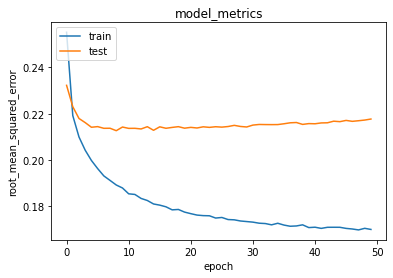

In [54]:
# Visualisasi RMSE
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Proses training model cukup smooth dan model konvergen pada epochs sekitar 50. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.17 dan error pada data validasi sebesar 0.21 . Nilai tersebut cukup bagus untuk sistem rekomendasi. 

### Mendapatkan Rekomendasi

Untuk mendapatkan rekomendasi film, pertama kita ambil sampel user secara acak dan definisikan variabel movie_not_watched yang merupakan daftar film yang belum pernah ditonton oleh pengguna

In [ ]:
movie_df = movie_new
df = pd.read_csv('/content/Movie_Recommendation/ratings.csv')
# mengambil data sebanyak 30000
df = df.iloc[:30000,:]

user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]
 

movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id'] 
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)
 
movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

In [ ]:
# untuk memperoleh rekomendasi restoran, gunakan fungsi model.predict() dari library Keras
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('movie with high ratings from user')
print('----' * 8)
 
top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_name, ':', row.genre)
 
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_name, ':', row.genre)

59/59 [==============================] - 0s 1ms/step
Showing recommendations for users: 106
movie with high ratings from user
--------------------------------
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Once Upon a Time in the West (C'era una volta il West) (1968) : Action|Drama|Western
Goodfellas (1990) : Crime|Drama
Amadeus (1984) : Drama
Dawn of the Dead (1978) : Action|Drama|Horror
--------------------------------
Top 10 movie recommendation
--------------------------------
Ran (1985) : Drama|War
Down by Law (1986) : Comedy|Drama|Film-Noir
High Noon (1952) : Drama|Western
Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983) : Documentary
Body Heat (1981) : Crime|Thriller
In the Mood For Love (Fa yeung nin wa) (2000) : Drama|Romance
Rise of the Planet of the Apes (2011) : Action|Drama|Sci-Fi|Thriller
Only Lovers Left Alive (2013) : Drama|Horror|Romance
Captain America: The Winter Soldier (2014) : Action|Adventure|S